In [ ]:
import torch
import torch.nn as nn
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from IPython.display import display
import math
import torch.nn.functional as F
from einops import rearrange
from tqdm import tqdm
import os

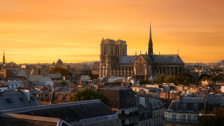

(224, 126)


In [ ]:
from PIL import Image

# Open the image
img = Image.open('/content/Screenshot (12).png')

# Get the original dimensions
width, height = img.size

# Define the target size while maintaining aspect ratio
target_size = 224
if width > height:
    new_width = target_size
    new_height = int((target_size / width) * height)
else:
    new_height = target_size
    new_width = int((target_size / height) * width)

# Resize and maintain aspect ratio
resized_img = img.resize((new_width, new_height))

# Display the resized image
display(resized_img)
print(resized_img.size)


no.of patches: 196
patches type:<class 'torch.Tensor'>
patches shape:torch.Size([196, 16, 16, 3])
patch type:<class 'torch.Tensor'>
patch shape:torch.Size([16, 16, 3])


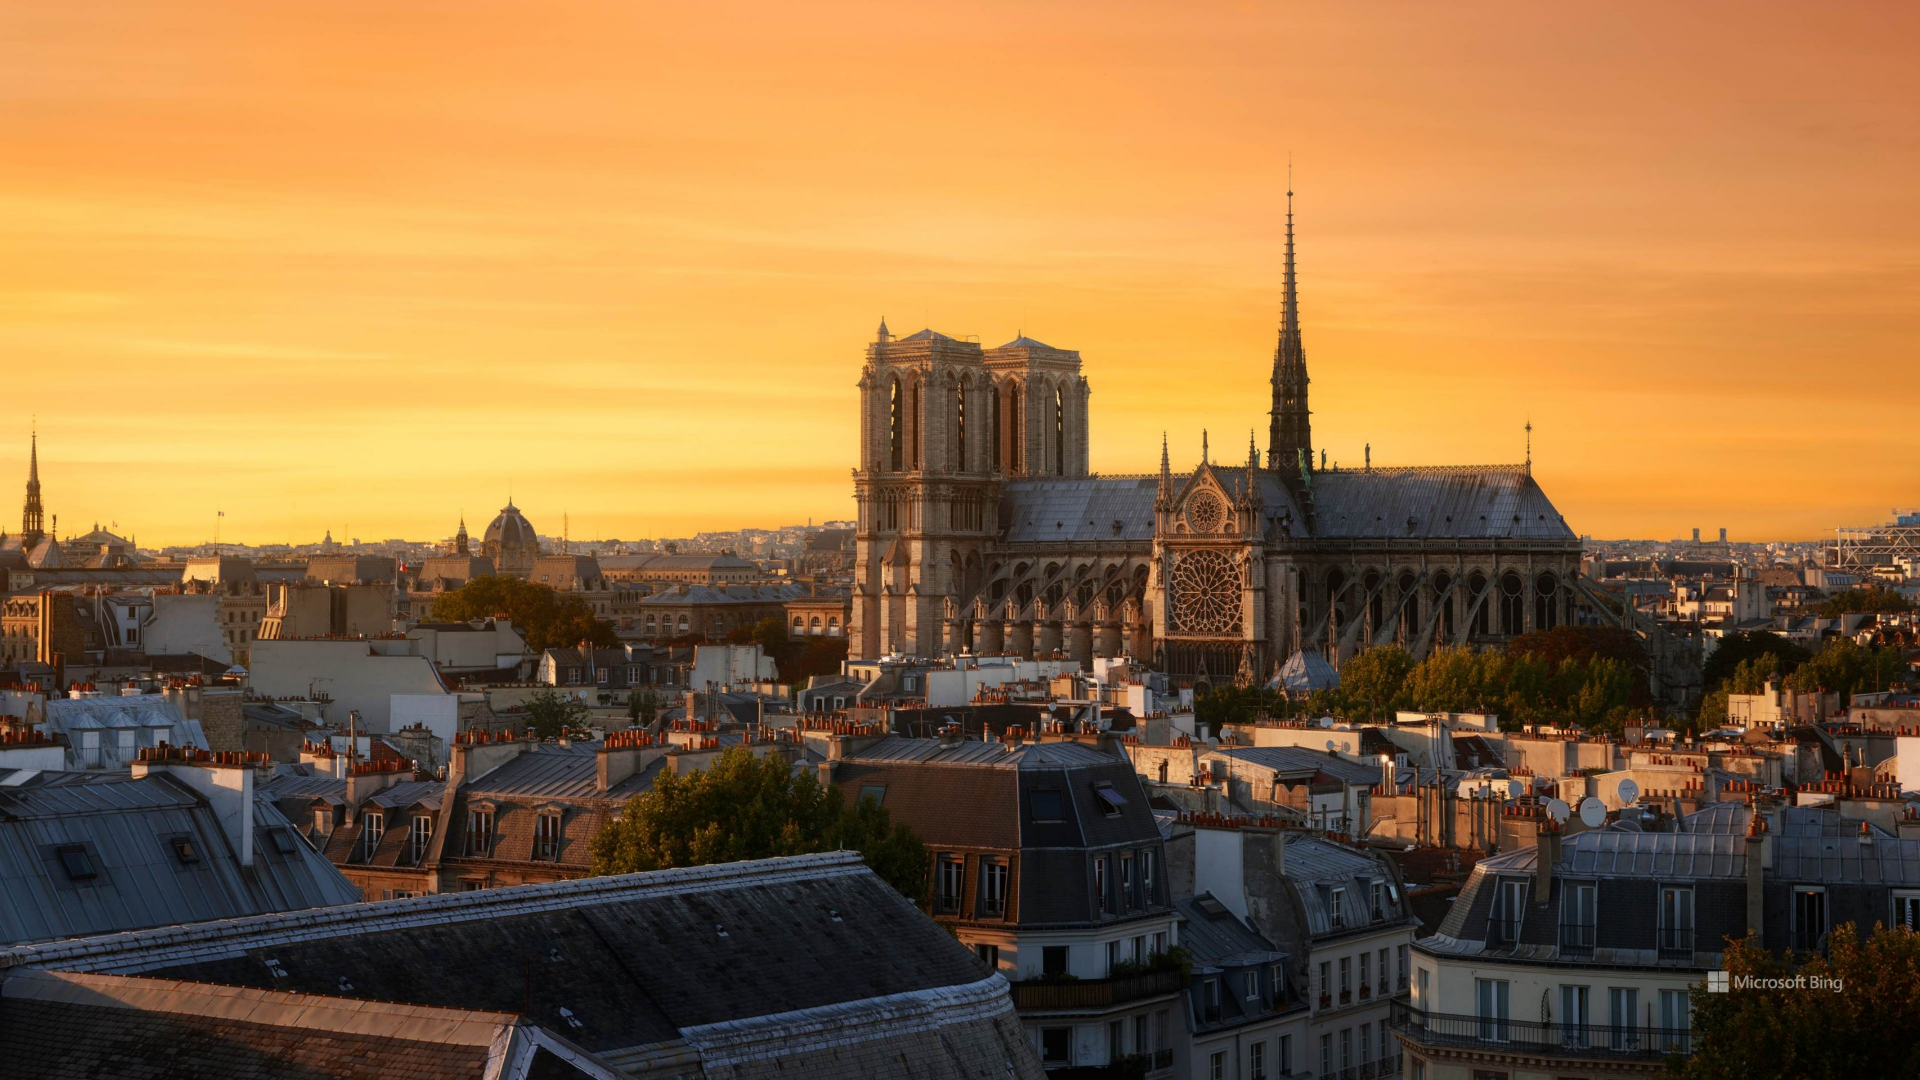

In [ ]:
def image_to_patches(image_path, patch_size=16):
    image = Image.open(image_path)
    image = image.convert("RGB")
    resized_img = image.resize((224,224))
    image = np.array(resized_img)
    patches = []

    height,width = image.shape[:2]

    for i in range(0,height,patch_size):
      for j in range(0,width,patch_size):
        patch = image[i:i+patch_size, j:j+patch_size]
        patches.append(patch)
    for index in range(len(patches)):
      patches[index] = torch.from_numpy(patches[index])
    return torch.stack(patches)

img = Image.open('/content/Screenshot (12).png')
patches = image_to_patches('/content/Screenshot (12).png')

print(f"no.of patches: {len(patches)}")
print(f"patches type:{type(patches)}")
print(f"patches shape:{patches.shape}")
print(f"patch type:{type(patches[0])}")
print(f"patch shape:{patches[0].shape}")

display(img)
display(Image.fromarray(patches[120].numpy()))

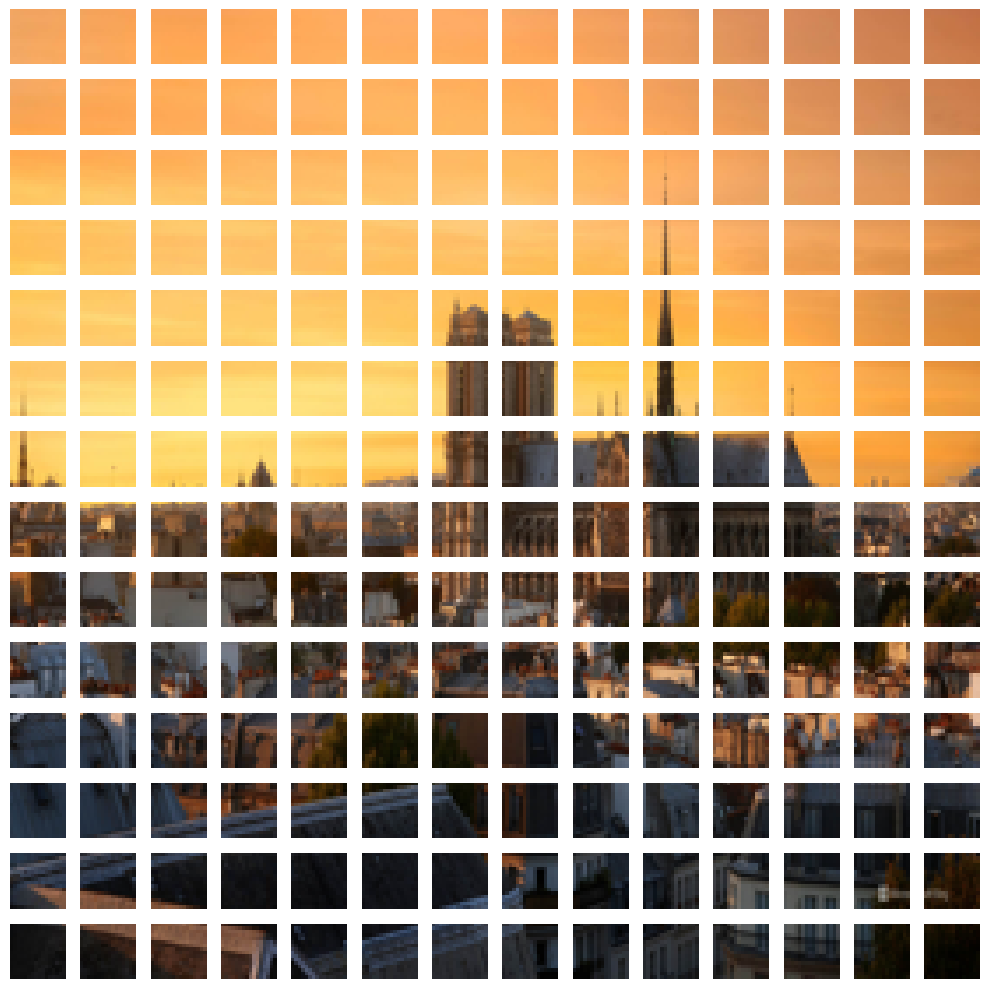

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def display_patches_in_grid(patches, grid_size):

    rows, cols = grid_size
    fig, axes = plt.subplots(rows, cols, figsize=(10, 10))

    patch_idx = 0  # Index to track patches
    for i in range(rows):
        for j in range(cols):
            if patch_idx < len(patches):
                # Show the patch in the subplot
                axes[i, j].imshow(patches[patch_idx].numpy())
                axes[i, j].axis('off')  # Turn off axes for better visualization
                patch_idx += 1
            else:
                axes[i, j].axis('off')  # Turn off axes if no patch is available

    # Display the grid of patches
    plt.tight_layout()
    plt.show()
display_patches_in_grid(patches,grid_size=(14,14))

In [ ]:
def flatten_patches(patches):
  patch_embeddings = []
  for patch in patches:
    flattened_patch = patch.view(-1)
    patch_embeddings.append(flattened_patch)
  return torch.stack(patch_embeddings)

x = flatten_patches(patches)
print(f"flats shape:{x.shape}")
print(f"embedding shape:{x[0].shape}")
# now 'x' will be passed as an input to the architecture

flats shape:torch.Size([196, 768])
embedding shape:torch.Size([768])


In [ ]:
class Linear(nn.Module):
  def __init__(self,fan_in, fan_out):
    super().__init__()
    self.w = nn.Parameter(torch.randn(fan_in,fan_out))
    self.bias = nn.Parameter(torch.randn(fan_out))


  def forward(self,x):
    x = x @ self.w + self.bias

    return x

# checking
x = torch.randn(1,10,1)

layer = Linear(1,512)
y = layer(x)
print(y)


tensor([[[-0.8370,  1.4476, -0.0688,  ...,  0.3756, -0.2538, -0.1040],
         [-1.1665,  2.6543, -0.4066,  ...,  0.7056, -0.4730, -0.5736],
         [-1.2807,  3.0723, -0.5236,  ...,  0.8199, -0.5489, -0.7363],
         ...,
         [ 1.0416, -5.4321,  1.8571,  ..., -1.5059,  0.9961,  2.5731],
         [-1.0288,  2.1498, -0.2654,  ...,  0.5676, -0.3813, -0.3773],
         [-1.4932,  3.8507, -0.7415,  ...,  1.0328, -0.6903, -1.0392]]],
       grad_fn=<AddBackward0>)


In [ ]:
y.shape

torch.Size([1, 10, 512])

In [ ]:
# class token
x_class = nn.Parameter(torch.randn(1,768))




# positional encoding
class PositionalEncoding(nn.Module):
  def __init__(self,seq_len,d_model):
     super().__init__()
     self.seq_len = seq_len
     self.d_model = d_model
    #  self.pe = self.sinusoidal()
     self.pe = self.learnablePE()


  def learnablePE(self):
    pe = nn.Parameter(torch.randn(1,self.seq_len,self.d_model))
    return pe


  def sinusoidal(self):
    pe = torch.zeros(self.seq_len,self.d_model)
    position = torch.arange(0, self.seq_len, dtype=torch.float).unsqueeze(1)
    div_terms = torch.exp(torch.arange(0,self.d_model,2, dtype=torch.float)* (-math.log(10000.0)/self.d_model))
    pe[:,0::2] = torch.sin(position*div_terms)   #even
    pe[:,1::2] = torch.cos(position*div_terms)   #odd
    return pe

  def forward(self,x): # x-->(b,t,c)
    x.add_(self.pe[:x.shape[1], :])
    return x

# checking
# x = torch.randn(1,10,768)
# y = x.clone()
# pe = PositionalEncoding(196,768)
# pe(x)
# y==x


In [ ]:
class SelfAttention(nn.Module):
  def __init__(self,d_model,head_size):
     super().__init__()
     self.head_size = head_size
     self.d_model = d_model
     self.Q = nn.Linear(d_model,head_size,bias=False)
     self.K = nn.Linear(d_model,head_size,bias=False) #b,t,dk
     self.V = nn.Linear(d_model,head_size,bias=False)

  def forward(self,x):
    Q = self.Q(x)
    K = self.K(x)
    V = self.V(x)
    attention_score = Q @ K.transpose(-1,-2) #b,t,t
    scaled_score = attention_score/math.sqrt(self.head_size) #b,t,t
    attention_weights = F.softmax(scaled_score,dim=-1)
    outputs = attention_weights @ V   # (b,t,t) @ (b,t,dk) ->> (b,t,dk)
    return outputs


class MultiHeadAttention(nn.Module):
  def __init__(self,d_model,num_heads):
     super().__init__()
     assert d_model % num_heads == 0
     self.num_heads = num_heads
     self.head_size = d_model // num_heads
     print(f"head size:{self.head_size}")
     self.QKV = nn.Linear(d_model,3 * num_heads*self.head_size,bias=False) #d_model = num_heads * head_size

  def forward(self,x): # b,t,c
    B,T,D = x.shape
    H = self.num_heads

    qkv = self.QKV(x) # b,t,3d_model
    qkv = qkv.view(B, T, H, 3 * self.head_size)
    Q, K, V = qkv.chunk(3, dim=-1) #(B,T,H,head_dim)

    Q = Q.permute(0, 2, 1, 3)  # (B, H, T, head_dim)
    K = K.permute(0, 2, 1, 3)  # (B, H, T, head_dim)
    V = V.permute(0, 2, 1, 3)  # (B, H, T, head_dim)

    attention_score = Q @ K.transpose(-1,-2) #(B,H,T,T)
    scaled_attention = attention_score / math.sqrt(self.head_size)
    attention_weights = F.softmax(scaled_attention,dim=-1)
    out = attention_weights @ V  #(B,H,T,head_dim)

    output = out.permute(0,2,1,3).contiguous().view(B,T,D)
    return output

# testing
x = torch.randn(2,5,768)
layer = MultiHeadAttention(768,8)
outs = layer(x)

head size:96


In [ ]:
outs==x


tensor([[[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]],

        [[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]]])

In [ ]:
class LayerNorm(nn.Module):
  def __init__(self,d_model,eps=1e-5) -> None:
     super().__init__()
     self.gamma = nn.Parameter(torch.ones(d_model))
     self.beta = nn.Parameter(torch.zeros(d_model))
     self.eps = eps

  def forward(self,x):
    x_mean = x.mean(dim=-1,keepdim=True)
    x_std = x.std(dim=-1,keepdim=True)
    x_cap = (x - x_mean)/ torch.sqrt((x_std**2)+ self.eps)
    out = self.gamma * x_cap + self.beta
    return out

# testing
x = torch.randn(2,5,10)
layer = LayerNorm(10)
out = layer(x)
out



tensor([[[ 0.6902, -0.1992,  0.1437,  1.4014, -1.5323,  0.6337,  0.5175,
          -0.7825, -1.5518,  0.6795],
         [-0.7816, -0.4884,  1.4635,  0.3056,  0.1340, -0.5339, -0.0698,
          -1.9275,  1.1624,  0.7357],
         [ 1.5504, -0.8078, -1.4500, -0.8443,  0.1339, -0.1016,  0.7633,
           0.9338, -0.9916,  0.8138],
         [ 0.2943, -0.3245,  1.3754,  1.6573,  0.2860, -0.1736, -0.3278,
          -0.4920, -0.4148, -1.8804],
         [ 1.2440, -0.1194, -1.2594,  0.9243, -1.7312,  0.3288, -0.9505,
           0.4095,  0.8560,  0.2978]],

        [[-0.1712,  1.1929,  0.8431, -0.0363,  0.4921, -1.7959,  0.5695,
          -1.6907,  0.2397,  0.3567],
         [-0.9302, -0.4902,  1.2479, -1.4389,  1.7312,  0.8163, -0.4016,
          -0.2602,  0.2731, -0.5475],
         [ 0.4511, -0.9553,  1.6688,  0.8775,  0.7450,  0.2091, -1.2238,
          -1.4737, -0.0594, -0.2395],
         [-2.0432,  0.9219,  1.6181,  0.1533, -0.2480, -0.2831,  0.1116,
           0.4861, -0.9442,  0.2275],

In [ ]:
class MLP(nn.Module):
  def __init__(self,input_size=768,output_size=3072) -> None:
     super().__init__()
     self.input_size = input_size
     self.output_size = output_size
     self.fc1= Linear(self.input_size,self.output_size)
     self.fc2= Linear(self.output_size,self.input_size)

  def forward(self,x):
    x = self.fc1(x)
    x = F.gelu(x)
    x = self.fc2(x)
    return x







In [ ]:
class TransformerEncoder(nn.Module):
  def __init__(self,d_model,num_heads) -> None:
     super().__init__()
     self.d_model = d_model
     self.num_heads = num_heads

     self.Lnorm1 = LayerNorm(self.d_model)
     self.MultiheadAttention = MultiHeadAttention(self.d_model,self.num_heads)
     self.Lnorm2 = LayerNorm(self.d_model)
     self.MLP = MLP()

  def forward(self,x):
     skip = x
     x = self.Lnorm1(x)
     x = self.MultiheadAttention(x)
     x = x + skip

     skip2 = x
     x = self.Lnorm2(x)
     x = self.MLP(x)
     x = x + skip2
     return x


In [ ]:

# Define input dimensions
batch_size = 2
seq_length = 5
d_model = 768
num_heads = 8

# Create a random input tensor (B, T, D)
x = torch.randn(batch_size, seq_length, d_model)

# Instantiate the model
encoder = TransformerEncoder(d_model, num_heads)

# Forward pass
output = encoder(x)

# Shape check
print("Input shape:", x.shape)       # Expected: (B, T, D)
print("Output shape:", output.shape) # Expected: (B, T, D)
assert output.shape == x.shape, "Output shape mismatch!"
print("Test Passed ✅")

head size:96
Input shape: torch.Size([2, 5, 768])
Output shape: torch.Size([2, 5, 768])
Test Passed ✅


In [ ]:
def patchify(img, patch_size=16):
    B, C, H, W = img.shape
    assert H % patch_size == 0 and W % patch_size == 0, "Image size must be divisible by patch size"

    patches = img.unfold(2, patch_size, patch_size).unfold(3, patch_size, patch_size)
    patches = patches.contiguous().view(B, C, H // patch_size, W // patch_size, patch_size, patch_size)
    patches = patches.permute(0, 2, 3, 1, 4, 5).reshape(B, (H // patch_size) * (W // patch_size), C * patch_size * patch_size)
    return patches

img = torch.randn(5,3,224,224)
patches = patchify(img)
patches.shape


torch.Size([5, 196, 768])

In [ ]:
class ViT(nn.Module):
  def __init__(self,image_size=224,d_model=768,num_classes=1000,num_trans_layers=3,patch_size=16,num_heads=8):
     super().__init__()
     self.num_patches = (image_size // patch_size) ** 2
     self.depth = num_trans_layers
     self.d_model = d_model
     self.proj = Linear(patch_size*patch_size*3,768)
     self.x_cls = nn.Parameter(torch.randn(1,1,self.d_model))
     self.PositionalEncoding = PositionalEncoding(seq_len=self.num_patches + 1,d_model=self.d_model)

     self.encoderLayers = nn.ModuleList([
            TransformerEncoder(d_model=d_model, num_heads=num_heads)
            for _ in range(self.depth)
        ])
     self.mlp_head = nn.Sequential(nn.LayerNorm(d_model),
            nn.Linear(d_model, num_classes))


  def forward(self,imgs):
    patches = patchify(imgs)
    x = self.proj(patches)
    B = x.size(0)
    cls_tokens = self.x_cls.expand(B, -1, -1)
    x = torch.cat((cls_tokens,x),dim=1)
    x = self.PositionalEncoding(x)
    for layer in self.encoderLayers:
      x = layer(x)

    cls_out = x[:,0]
    logits = self.mlp_head(cls_out)
    return logits







In [ ]:
440*440*3

580800

In [ ]:
vit = ViT()
img = torch.randn(4, 3, 224,224)  # batch of 4 images
logits = vit(img)


head size:96
head size:96
head size:96


#training

In [ ]:
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader

transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to match ViT input size
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Normalize to [-1, 1]
])

train_data = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_data = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_data, batch_size=64, shuffle=True, num_workers=2)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False, num_workers=2)


In [ ]:
images, labels = next(iter(train_loader))
print(f"Image batch shape: {images.shape}")
print(f"Labels batch shape: {labels.shape}")


Image batch shape: torch.Size([64, 3, 224, 224])
Labels batch shape: torch.Size([64])


In [ ]:
import torch.optim as optim
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ViT(num_heads=12,num_classes=10).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=3e-4)

head size:64
head size:64
head size:64


In [ ]:
def save_checkpoint(model, optimizer, epoch, loss, filename="vit_checkpoint.pth"):
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss,
    }, filename)

def load_checkpoint(model, optimizer, filename="vit_checkpoint.pth"):
    checkpoint = torch.load(filename)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    loss = checkpoint['loss']
    print(f"Loaded checkpoint from epoch {epoch} with loss {loss:.4f}")
    return epoch + 1  # start from next epoch


In [ ]:
def train(model,criterion,optimizer,dataloader,device,epoch,num_epoch):
  model.train()
  total_loss = 0
  total = 0
  correct = 0

  for images,labels in tqdm(dataloader, desc=f"Epoch {epoch+1}/{num_epoch}"):
    images,labels = images.to(device),labels.to(device)

    optimizer.zero_grad()
    prediction = model(images)
    loss = criterion(prediction,labels)
    loss.backward()  #calculate gradient
    optimizer.step() #update weights
    total_loss += loss.item()
    _, preds = prediction.max(1)
    correct += preds.eq(labels).sum().item()
    total += labels.size(0)
    avg_loss = total_loss/len(dataloader)
    accuracy = 100 * correct/total
  print(f"Epoch {epoch}/{num_epoch}: Train Loss = {total_loss/len(dataloader):.4f}, Accuracy = {accuracy}%")
  save_checkpoint(model, optimizer, epoch,avg_loss)
  return total_loss,accuracy

def validate(model,criterion,dataloader,device):
  model.eval()
  total_loss = 0
  total = 0
  correct = 0

  with torch.no_grad():
    for images, labels in tqdm(dataloader,desc=f"validation"):
      images,labels = images.to(device),labels.to(device)
      prediction = model(images)
      loss = criterion(prediction,labels)


      total_loss += loss.item()
      _, preds = prediction.max(1)
      correct += preds.eq(labels).sum().item()
      total += labels.size(0)
      accuracy = 100 * correct/total
  print(f"Validation: Loss = {total_loss/len(dataloader):.4f}, Accuracy = {100 * correct/total:.2f}%")
  return total_loss, accuracy



In [ ]:
EPOCHS = 10
history={'train_loss':[], 'val_loss':[],'train_acc':[],'val_acc':[]}
if os.path.exists("vit_checkpoint.pth"):
  start_epoch = load_checkpoint(model, optimizer, "vit_checkpoint.pth")

for epoch in range(EPOCHS):

  loss,acc = train(model,criterion=criterion,optimizer=optimizer,dataloader=train_loader,device=device,epoch=epoch,num_epoch=EPOCHS)
  history['train_loss'].append(loss)
  history['train_acc'].append(acc)
  val_loss,val_acc = validate(model,criterion=criterion,dataloader=test_loader,device=device)
  history['val_loss'].append(val_loss)
  history['val_acc'].append(val_acc)


In [ ]:
# prompt: plot history dict

import matplotlib.pyplot as plt

# Assuming 'history' dictionary is already populated from your training loop

plt.figure(figsize=(10, 5))

# Plot training and validation loss
plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history['train_acc'], label='Training Accuracy')
plt.plot(history['val_acc'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()
